In [0]:
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip

In [0]:
#######################################
####     Add new region      ##########
#### Uploads Indian.txt file ##########
## Find here at my github:   ##########
## https://github.com/asimniazi63/NLP-name-classification-and-generation.git ##
#######################################

In [3]:
# Clone into repo for downloading data
!git clone https://github.com/asimniazi63/NLP-name-classification-and-generation.git

Cloning into 'NLP-name-classification-and-generation'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 4), reused 31 (delta 2), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [0]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-@"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('NLP-name-classification-and-generation/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 19 ['Indian', 'Arabic', 'Russian', 'German', 'Vietnamese', 'Czech', 'Portuguese', 'Chinese', 'Dutch', 'Spanish', 'Italian', 'Polish', 'Greek', 'Japanese', 'Irish', 'English', 'Korean', 'Scottish', 'French']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
n_letters

60

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [13]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 200000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
  try:
    output, loss = train(*randomTrainingExample())
    total_loss += loss
  except:
    #ignore invalid line i.e. names in hindi langaue
    continue
  
  if iter % print_every == 0:
      print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

  if iter % plot_every == 0:
      all_losses.append(total_loss / plot_every)
      total_loss = 0

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


0m 13s (5000 2%) 2.7148
0m 27s (10000 5%) 3.0415
0m 40s (15000 7%) 2.7299
0m 54s (20000 10%) 1.9087
1m 6s (25000 12%) 2.7771
1m 20s (30000 15%) 2.4268
1m 33s (35000 17%) 2.2249
1m 46s (40000 20%) 2.6672
1m 59s (45000 22%) 2.4688
2m 13s (50000 25%) 1.5115
2m 40s (60000 30%) 2.2332
2m 53s (65000 32%) 2.6190
3m 6s (70000 35%) 2.4591
3m 19s (75000 37%) 2.3466
3m 32s (80000 40%) 1.7874
3m 44s (85000 42%) 1.1686
3m 57s (90000 45%) 2.3601
4m 10s (95000 47%) 1.6917
4m 23s (100000 50%) 2.4545
4m 36s (105000 52%) 3.0411
4m 49s (110000 55%) 1.7771
5m 2s (115000 57%) 2.6041
5m 14s (120000 60%) 2.9146
5m 27s (125000 62%) 2.5812
5m 40s (130000 65%) 2.6027
5m 53s (135000 67%) 3.0171
6m 5s (140000 70%) 1.9122
6m 18s (145000 72%) 2.8052
6m 31s (150000 75%) 2.1097
6m 44s (155000 77%) 2.5519
6m 57s (160000 80%) 2.2036
7m 10s (165000 82%) 2.0962
7m 23s (170000 85%) 2.0263
7m 37s (175000 87%) 2.4094
7m 50s (180000 90%) 2.6098
8m 3s (185000 92%) 2.2287
8m 16s (190000 95%) 2.6761
8m 29s (195000 97%) 2.8174
8

Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




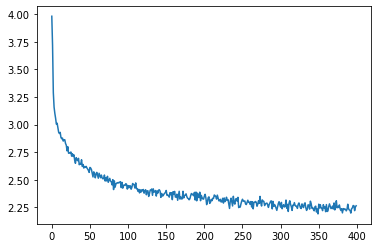

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [15]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Indian', 'IND')
samples('Indian', 'RPA')
samples('Indian', 'AKL')

print("")
samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Iran
Nahar
Dani
Rami
Panda
Ander
Ander
Kanim
Lan

Grang
Eres
Reis
Salla
Pare
Alan
Cha
Hua
Iin
